**For reference:**
- https://pubchem.ncbi.nlm.nih.gov/compound/2519
- https://rruff.info/caffeine/display=default/


In [1]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy.interpolate as interp
from joblib import load

!python --version

Python 3.11.8


In [2]:
## LOAD COMPOUND NAMES TO BE PROCESSED
COMPOUNDS = []

# NOTE: compounds_all.json is the names of a collection of compounds found on a site affiliated with rruff.com
# Load all compounds
# with open("compounds_all.json") as f:
#   COMPOUNDS = json.load(f)

# NOTE: compounds_exist.json is a subset of compounds in compounds_all.json which actually exists in the rruff database
# Load rruff existing compounds
# with open("compounds_exist.json") as f:
#   COMPOUNDS = json.load(f)

# NOTE: compounds_w_melting_point.json is a subset of compounds in compounds_all.json which also have melting point data on PubChem
# Load only compounds with melting points
with open("compounds_w_melting_point.json") as f:
  COMPOUNDS = json.load(f)
  print("Number of relevant compounds:", len(COMPOUNDS))

Number of relevant compounds: 74


In [3]:
def save_dataset_to_file(dataset, outpath="", format="pickle"):
    #TODO: should handle types beside 'pickle'
    timestamp = datetime.now()
    outpath = outpath.format(timestamp)
    with open(outpath, 'wb') as pickle_file:
        pickle.dump(dataset, pickle_file)


def get_links(response):
  # Parse the HTML content
  soup = BeautifulSoup(response.text, 'html.parser')
  links = soup.find_all('a', href=True)
  return links


def get_page(url):
  response = requests.get(url)
  if response.status_code == 200:
    return response
  else:
    print(f'ERROR: get_page() failed to retrieve the page, status code: {response.status_code}, url: {url}')
    return None


def get_compound_spectral_data(compound, source="rruff"):
  spectral_data = None

  if source != "rruff":
    print("ERROR: source not configured")
    return

  url = f"https://rruff.info/{compound}"
  response = get_page(url)

  if "No Records Found" in response.text:
    print(f"\t*NOTE: no records found on {source} for compound {compound}. Skipping...")
    return None

  # If multiple search results, choose one and navigate there instead
  # (if appropriate link wasn't found, look for a link to that link)
  if "Search Results" in response.text:
    links = get_links(response)
    for link in links:
      if compound in link['href']:
        url = "https://rruff.info" + link['href']
        response = get_page(url)
        break

  links = get_links(response)

  for link in links:
    if "sample_child_record_raman" in link['href']:
      if "jpg" in link['href']: continue #ignore false jpg urls
      if "xls" in link['href']: continue #ignore false xls urls
      url_spectral = link['href']
      response = requests.get(url_spectral)
      if response.status_code != 200: print("ERROR")

      text = response.text
      # print(text)
      text = text.replace("\r", "")
      lines = text.split("\n")
      for idx in range(len(lines)):
        if "##" not in lines[idx]: break
      spectral_data = lines[idx:-5] #removes the 4 garbage lines at the end
      spectral_data = np.array([np.array(entry.split(", "), dtype=float) for entry in spectral_data]) #TODO: would go back and write a more efficient way to write this function
      return spectral_data

  return spectral_data


def get_compound_cid(compound_name):
    """Fetch the CID for a given compound name."""
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    url = f"{base_url}/compound/name/{compound_name}/cids/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        cids = data.get('IdentifierList', {}).get('CID', [])
        if cids:
            return cids[0]  # For now, if there are multiple search results, just returns the first result's CID
    return None


def get_compound_pubchemn_data():
  '''Gets other data associated with compound using PubChem API'''
  url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/JSON"
  response = get_page(url)
  if response:
    pubchem_compound_data = response.json()  # Convert the response to JSON
    pubchem_compound_data = pubchem_compound_data['PC_Compounds'][0] #remove top layer of returned dictionary
    return pubchem_compound_data

In [4]:
## CODE FOR GETTING/SCRAPING COMPOUND MELTING POINT DATA

def celsius_conversion(temp, metric, cmpd_name):
  '''
  - Tries converting non Celsius temperature to Celsius
  - If given metric is neither 'F' nor 'K', will return None
  '''
  if metric == 'F':
    return (temp - 32) * 5/9
  elif metric == 'K':
    return temp - 273.15
  else:
    print(f"WARNING: ({cmpd_name}) - unexpected temperature unit extracted. Skipping...")
    return None


def extract_melting_pt(full_str, cmpd_name):
  '''
  - Given a string containing melting point temperature data, returns the melting
    as a float in degrees Celsius
  - Strings must be formatted in the following way, otherwise this function
    returns None
  - If melting point not found in string (ie, if string's format fall's outside of function's assumptions) returns None
  '''

  if "°" not in full_str:
    print(f"WARNING: ({cmpd_name}) - no °degree char found in string. Skipping...") #DEBUG
    print(f"\t - Relevant string: {full_str}") #DEBUG
    return None

  delimed_1 = full_str.split("°")
  delimed_1[0] = delimed_1[0].strip() # remove leading/trailing white space
  delimed_2 = delimed_1[0].split(" ")
  temperature_str = delimed_2[-1]
  temperature_str = delimed_2[-1].replace(',', '')

  # Account for cases with unexpected chars
  if not temperature_str.replace('-','').replace('.','').isnumeric(): #TODO: would go back and use a more extensive regex pattern here
    print(f"WARNING: ({cmpd_name}) skipping this extration due to presence of unexpected symbols.\n\tRelevant string: {full_str}")
    return None

  # Account for cases where the value is given as a range
  if "-" in temperature_str:
    #TODO: skipping for now, but should eventually account for cases where there
    # are more than one '-' symbols
    if temperature_str.count('-') > 1:
      print(f"WARNING: ({cmpd_name}) skipping this extration value due to excessive number of interpretations of the '-' symbol. \n\tRelevant string: {full_str}") #DEBUG
      return None
    # if first char is '-' and only one, then probably negative sign (which will
    # means no changes need to be made here)
    elif temperature_str[0] == '-':
      pass
    # if only one '-' char and it's not the first, than it's probably a range of
    # values and we will deide to take the first value
    else:
      temperature_str = temperature_str.split('-')[0] #NOTE: always takes min of range

  temperature_float = float(temperature_str)
  metric = delimed_1[1][0] # gets the first charcter after the deg symbol

  # Convert temperature units to Celsius if needed
  if metric != 'C':
    temperature_float = celsius_conversion(temperature_float, metric, cmpd_name)

  return temperature_float


# Main function call to get melting point data
def get_melting_point(cmpd_name, cmpd_cid):
  url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cmpd_cid}/JSON'

  # Make the PubChem API request
  response = get_page(url)
  if not response: return None

  #NOTE: can be generalized to other properties pretty easily by changing this search query
  search_query = "Melting Point" # other example: "Solubility", "Boiling Point"
  if search_query not in response.text:
    return None
  else:
    data = response.json()

    # Find the melting point key in the json dict
    Chemical_Physical_Properties_Section = data['Record']["Section"][3]["Section"]
    for sub_section in Chemical_Physical_Properties_Section:
      if sub_section["TOCHeading"] == "Experimental Properties":
        for sub_sub_section in sub_section["Section"]:
          if sub_sub_section["TOCHeading"] == search_query:
            meltpt_string_entry = sub_sub_section["Information"][0]["Value"]

            if "StringWithMarkup" in meltpt_string_entry: # if melting represented as String
              meltpt_string = meltpt_string_entry["StringWithMarkup"][0]["String"]
              melting_pt = extract_melting_pt(meltpt_string, cmpd_name)
              if melting_pt == None:
                return None

            elif "Number" in meltpt_string_entry: # if melting represented as Number
              melting_pt = float(meltpt_string_entry["Number"][0])
              if "Unit" not in meltpt_string_entry:
                print(f"WARNING: ({cmpd_name}) - extracted {search_query} has no listed metric. Skipping...")
                return None
              metric = meltpt_string_entry["Unit"][1]
              if metric != 'C':
                melting_pt = celsius_conversion(melting_pt, metric)

            else: # if represented as neither String nor Number #TODO: could expand to other type handling in future
              print(f"ERROR: value of found {search_query} is formatted in unexpected type")
              return None

            return melting_pt

In [5]:
## MAIN FUNCTIONS FOR GETTING COMPOUND DATA/POPULATING DATABASE

# Compile data for a single compound
def compile_compound(compound, get_all=False):
  compound_data = {}

  # Get PubChem CID
  cid = get_compound_cid(compound)
  if cid is None:
    # for now, skip saving in our database if no pubchem CID found
    return None
  compound_data["pubchem_cid"] = cid

  # Get Melting Point (from PubChem)
  if compound_data.get("pubchem_cid"):
    melt_pt = get_melting_point(compound, cid)
    if melt_pt:
        compound_data["melting_point"] = melt_pt
    else:
      # for now, skip saving in our database if no melting point found
      return None

  # Get PubChem other data
  if get_all:
    pubchem_compound_data = get_compound_pubchemn_data(compound)
    compound_data.update(pubchem_compound_data)

  ## Get RRUFF data (spectral)
  spectral_data = get_compound_spectral_data(compound, source="rruff")
  if spectral_data is None: #NOTE: since raman spectral is currently the only relevant data, will skip entering compound in our database if it's not found
    return None
  compound_data["spectral"] = spectral_data

  return compound_data


# Compile data for a given list of compounds (returns pandas dataframe)
def make_dataset(compound_list):
  columns = ['pubchem_cid', 'melting_point', 'spectral']
  df = pd.DataFrame(columns=columns)

  for compound_name in compound_list:
    compound_data = compile_compound(compound_name)
    if compound_data is not None:
      df.loc[compound_name] = compound_data
      print(f"Compiled data for: '{compound_name}'")

  return df

Returned compiled data for 'caffeine':
 {'pubchem_cid': 2519, 'melting_point': 237.77777777777777, 'spectral': array([[ 167.5252,  238.9841],
       [ 169.4537,  271.7816],
       [ 171.3822,  306.5219],
       ...,
       [5495.879 ,  121.77  ],
       [5497.808 ,  119.9524],
       [5499.736 ,  120.3498]])}


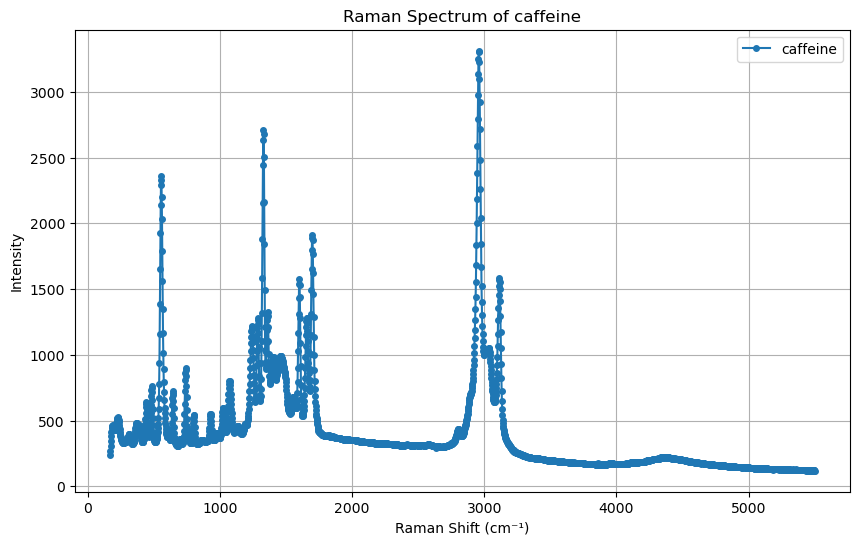

In [6]:
## TEST CODE WITH SINGLE DATAPOINT AND MAKE SAMPLE PLOT OF SPECTAL DATA
compound_name = input("Enter the name of the compound (example: 'caffeine'): ") # Examples: 'aspirin', 'caffeine', 'sulphur'
datum = compile_compound(compound_name)
print(f"Returned compiled data for '{compound_name}':\n", datum)

# Extracting Raman shift and intensity values
raman_shifts = []
intensities = []
for point in datum["spectral"]:
  shift, intensity = point
  raman_shifts.append(shift)
  intensities.append(intensity)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(raman_shifts, intensities, '-o', markersize=4, label=compound_name)
plt.title(f'Raman Spectrum of {compound_name}')
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
## MAKE SAMPLE DATABASE 
# Here we will make a sample database, focusing specifcally on compounds with available raman spectral data
dataset = make_dataset(COMPOUNDS)
save_dataset_to_file(dataset, "dataset_MELT_ONLY_{}.pkl", format="pickle")
print("\ndataset length:", len(dataset))
dataset

Compiled data for: 'Aluminium'
Compiled data for: 'Anatase'
Compiled data for: 'Anglesite'
Compiled data for: 'Anhydrite'
Compiled data for: 'Antimony'
Compiled data for: 'Aragonite'
Compiled data for: 'Arsenic'
Compiled data for: 'Baryte'
Compiled data for: 'Beryl'
Compiled data for: 'Bismite'
Compiled data for: 'Bismuth'
Compiled data for: 'Borax'
Compiled data for: 'Brookite'
Compiled data for: 'Bunsenite'
Compiled data for: 'Calcite'
Compiled data for: 'Cassiterite'
Compiled data for: 'Chrysotile'
Compiled data for: 'Coesite'
Compiled data for: 'Copper'
Compiled data for: 'Cristobalite'
Compiled data for: 'Cryolite'
Compiled data for: 'Diamond'
Compiled data for: 'Erythrite'
Compiled data for: 'Galena'
Compiled data for: 'Graphite'
Compiled data for: 'Greenockite'
Compiled data for: 'Gypsum'
Compiled data for: 'Halite'
Compiled data for: 'Hausmannite'
Compiled data for: 'Hematite'
Compiled data for: 'Hoelite'
Compiled data for: 'Hydroboracite'
Compiled data for: 'Hydrocerussite'
Co

,pubchem_cid,melting_point,spectral
Aluminium,5359268,660.000000,"[[158.4944, 2414.221], [160.4229, 2449.127], [..."
Anatase,26042,1860.000000,"[[79.84985, 0.0], [81.77832, 24506.01], [83.70..."
Anglesite,24008,1170.000000,"[[110.6727, 3130.156], [112.6011, 3557.885], [..."
Anhydrite,24497,1560.000000,"[[104.8873, 114.8248], [106.8157, 126.2533], [..."
Antimony,5354495,630.722222,"[[128.416, 154.0758], [130.3445, 211.8636], [1..."
...,...,...,...
Tin,5352426,231.666667,"[[130.402, 3021.51], [132.331, 3014.138], [134..."
Tridymite,24261,1710.000000,"[[137.2813, 402.7835], [139.2097, 450.7003], [..."
Villiaumite,5235,992.777778,"[[138.1169, 4466.501], [140.0454, 4559.639], [..."
Witherite,10563,811.000000,"[[126.6641, 8152.064], [128.5926, 9228.084], [..."


In [9]:
# Function for creating training dataset of entires with consistent feature sizes
def resample_spectrum(spectrum, target_length=500):
    # Assumes spectrum is an Nx2 array where first column is wavelength and second column is the intensity
    x_old = spectrum[:, 0]
    y_old = spectrum[:, 1]

    # New wavelength scale (linear space between min and max of original wavelengths)
    x_new = np.linspace(x_old.min(), x_old.max(), target_length)

    # Interpolating the y-values to the new wavelength scale
    interpolator = interp.interp1d(x_old, y_old, kind='linear', fill_value='extrapolate')
    y_new = interpolator(x_new)

    # Returning the new resampled spectrum
    return np.column_stack((x_new, y_new))

In [10]:
## GENERATING PREDICTIVE MODEL

# Format training data
print("Preparing data for training...")
dataset['resampled_spectrum'] = dataset['spectral'].apply(resample_spectrum)
X = np.stack(dataset["resampled_spectrum"].to_numpy()) # Get spectral data as Nx1000x2 ndarray
X = X[:,:,1] # Removing wavelength column
y = dataset.loc[:,["melting_point"]].squeeze()

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initializing and training the Random Forest model
#NOTE: Random Forest is jused just as an easy Proof of Concept. In actuality, there are better models to use, such as SVM, LSTM, etc.
print("Training model...")
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Evaluating model on test set
print("Evaluating model...")
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Test set performance: Mean Squared Error: {mse}')

# Save model weights
dump(model, 'model_saved_1.joblib')

Preparing data for training...
Training model...
Evaluating model...
Test set performance: Mean Squared Error: 852401.1610366331


['model_saved_1.joblib']

In [11]:
# SIMULATE ONLINE USE OF MODEL

# Load the model
model_filepath = "model_saved_1.joblib"
model = load(model_filepath)

# Sample compound
compound_name = "Sulphur" #"Aspirin" #"Caffeine"

# Get sample compound's spectral data (in order to make model prediction)
new_datapoint = compile_compound(compound_name)
gtruth_spectral_data = resample_spectrum(new_datapoint['spectral'])[:,1]
gtruth_melting_point = get_melting_point(compound_name, new_datapoint["pubchem_cid"])

# Make model prediction
predicted_melting_point = model.predict([gtruth_spectral_data])
print(f'{compound_name}\'s predicted melting point: {predicted_melting_point[0]}')
print(f'{compound_name}\'s ground truth melting point: {gtruth_melting_point}')


Sulphur's predicted melting point: 393.26644444444463
Sulphur's ground truth melting point: 95.3
